In [2]:
%load_ext autoreload
%autoreload 2
  
from google.colab import drive
import sys
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
base = Path('/content/drive/My Drive/Instance segmentation')
sys.path.append(str(base))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive


In [3]:
import os
os.chdir("/")
os.chdir("content/drive/My Drive/Instance segmentation")
os.listdir()

['train2017', 'annotations', 'val2017', 'Test.ipynb']

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from copy import copy, deepcopy

from PIL import Image

from pycocotools import mask as maskUtils
from pycocotools.coco import COCO
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data as data

import tqdm
from torchsummary import summary

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

In [ ]:
!unzip 'train2017.zip'
!unzip 'val2017.zip'
!unzip 'annotations_trainval2017.zip'

!rm 'train2017.zip'
!rm 'val2017.zip'
!rm 'annotations_trainval2017.zip'

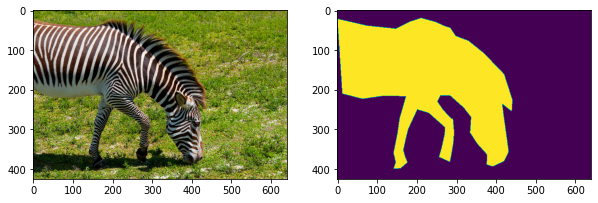

In [ ]:
#just see what's inside
img, [target] = train_data[3]

fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1,2,1)
plt.imshow(img.numpy().transpose((1, 2, 0)));

fig.add_subplot(1,2,2)
mask = train_data.coco.annToMask(target)
plt.imshow(mask);

##Prepare data

In [5]:
# https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning
class CocoDataset(data.Dataset):
  def __init__(self, root, json, transform=None):
    self.root = root
    self.coco = COCO(json)
    self.json = json
    self.ids = list(self.coco.anns.keys())
    self.transform = transform

  def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        ann_id = self.ids[index]
        #img_id = coco.anns[ann_id]['image_id']
        #path = coco.loadImgs(img_id)[0]['file_name']
        mask = coco.annToMask(coco.anns[ann_id])
        
        #image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
        #    image = self.transform(image)
            mask = self.transform(mask)

        return mask
       # return image, coco.anns[ann_id]

  def __len__(self):
        return len(self.ids)


def get_loader(root, json, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco = CocoDataset(root=root,
                       json=json,
                       transform=transform)
    
    # Data loader for COCO dataset
    data_loader = torch.utils.data.DataLoader(dataset=coco, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers)
    return data_loader

In [6]:
transform = transforms.Compose(
      [transforms.ToPILImage(),
       transforms.Scale(256),
       transforms.CenterCrop(224),
       transforms.ToTensor()]
    #   transforms.Normalize(mean=[0.485, 0.456, 0.406]
    #                              std=[0.229, 0.224, 0.225])]
  )

val_loader = get_loader(root='val2017', 
                        json='annotations/instances_val2017.json',
                        transform=transform,
                        batch_size=16,
                        shuffle=True,
                        num_workers=0)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


loading annotations into memory...
Done (t=1.18s)
creating index...
index created!


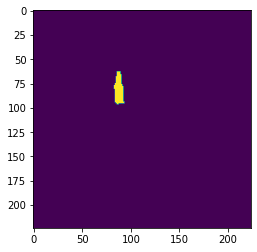

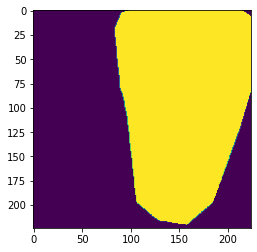

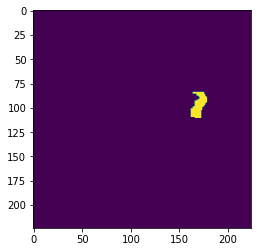

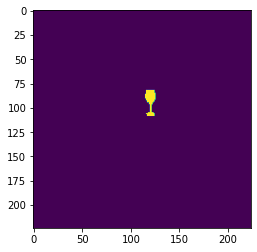

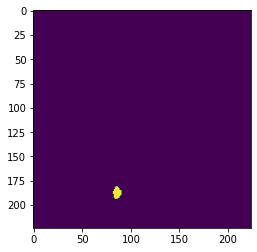

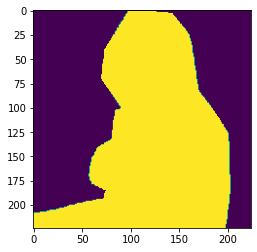

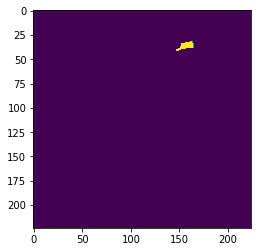

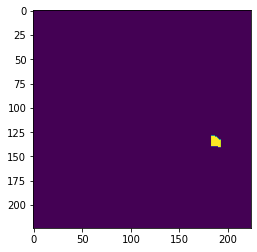

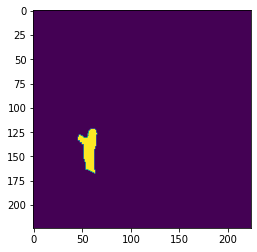

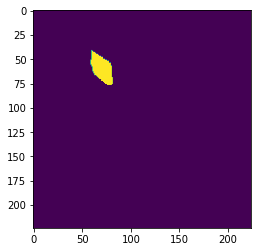

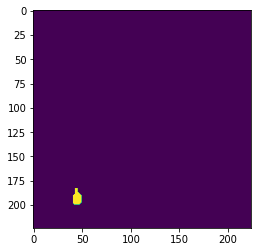

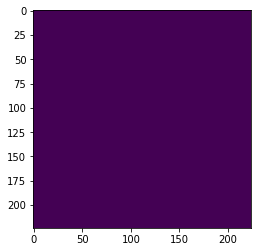

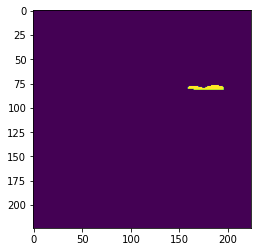

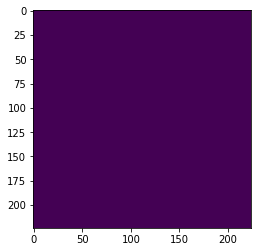

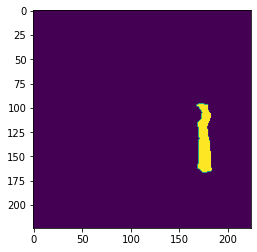

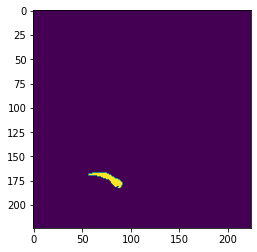

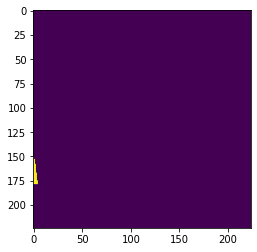

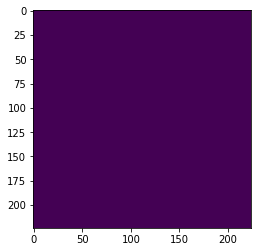

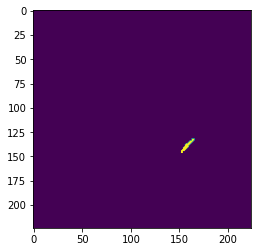

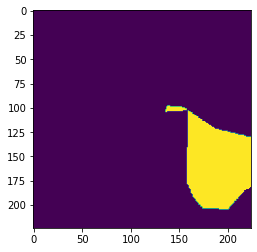

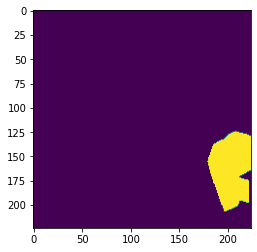

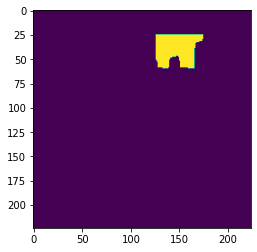

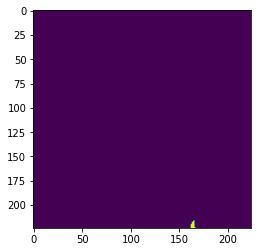

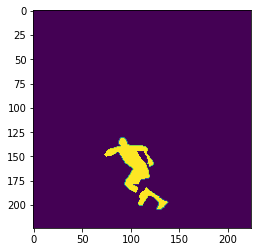

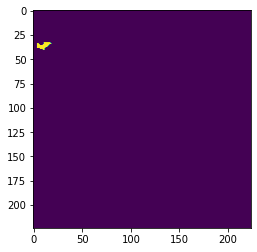

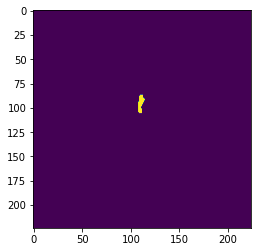

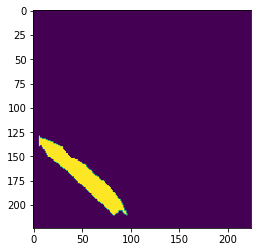

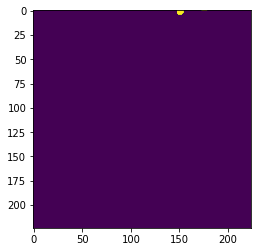

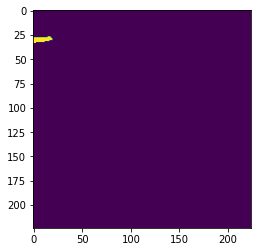

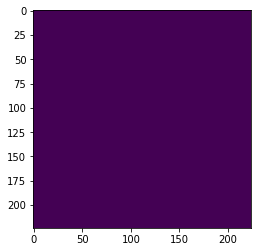

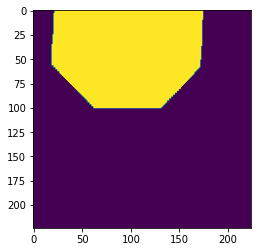

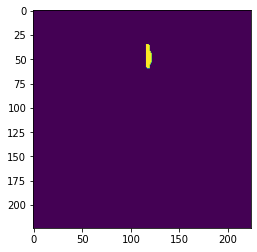

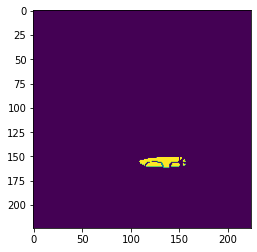

KeyboardInterrupt: ignored

In [7]:
for images in val_loader:
    # image shape is [batch_size, 3 (due to RGB), height, width]
    img = transforms.ToPILImage()(images[0])
    plt.imshow(img)
    plt.show()
   # print(labels)

##Autoencoder

In [19]:
def train_autoencoder(model, criterion, optimizer, dataloader, num_epochs, epoch_len=100):
  

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  batch_size = 16

  model.train()
  best_model_wts = deepcopy(model.state_dict())
  best_loss = 10000.
  loss_history = []
  for epoch in range(num_epochs):
    running_loss = 0
    for i in tqdm.trange(epoch_len):
        inputs = next(iter(dataloader))

        # variable image size
        k = np.random.randint(15, 20)
        inputs = F.interpolate(inputs, (k*16, k*16))

        inputs = Variable(inputs.to(device))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = running_loss / len(dataloader.dataset)
    loss_history.append(epoch_loss)
    if epoch_loss < best_loss:
        best_model_wts = deepcopy(model.state_dict())
    print('epoch [{}/{}], loss:{:.4f}\n'.format(epoch+1, num_epochs, loss.item()))

  model.load_state_dict(best_model_wts)
  return model, loss_history

In [85]:
class DiceLoss(nn.Module):
  def __init__(self) -> None:
        super(DiceLoss, self).__init__()
        self.eps = 1e-6
        self.th = 0.5
  def forward(self, inp, out):
        # shape [batch_size, 3, 224, 224]
        dims = (1, 2, 3)
        intersection = torch.sum(inp * out, dims)
        cardinality = torch.sum(inp + out, dims)
        dice_score = 2. * intersection / (cardinality + self.eps)
        return torch.mean(dice_score)


class FocalLoss(nn.Module):
  def __init__(self, alpha=1., gamma=1.) -> None:
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
  def forward(self, inp, out):
        # shape [batch_size, 3, 224, 224]

        BCE_loss = F.binary_cross_entropy(inp, out, reduce=False)
        pt = torch.exp(-BCE_loss)
        f_loss = -self.alpha * (1 - pt)**self.gamma * BCE_loss

        
        logit = inp.clamp(1e-3, 1. - 1e-3)
        loss = -1 * torch.log(logit) * out.float() # cross entropy
        loss = self.alpha * loss * (1 - logit) ** self.gamma # focal loss
        loss = torch.mean(loss)
        
        return -f_loss.mean()


        #return f_loss.mean()

class Loss(nn.Module):
  def __init__(self) -> None:
        super(Loss, self).__init__()

  def forward(self, inp, out):
        # shape [batch_size, 3, 224, 224]
        f = FocalLoss(gamma=5)
        d = DiceLoss()
        #print(f(inp,out), d(inp, out))
        return f(inp,out) - 15*d(inp, out)

In [86]:
class NaiveAutoencoder(nn.Module):
  def __init__(self):
        super(NaiveAutoencoder, self).__init__()
        # encoder layers
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder layers
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2, padding=0)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2, padding=0)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    
  def forward(self, x):
        # encode
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation

        # decode
        x = self.relu(self.t_conv1(x))
        x = self.sigmoid(self.t_conv2(x))
        return x
  


In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NaiveAutoencoder().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
criterion = Loss()
num_epochs = 5

In [88]:
naive_autoencoder, loss_history_ae = train_autoencoder(model,criterion, opt, val_loader, num_epochs)


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  2%|▏         | 2/100 [00:00<00:07, 12.36it/s]

epoch [1/5], loss:-0.0032



  2%|▏         | 2/100 [00:00<00:07, 12.37it/s]

epoch [2/5], loss:-0.0060



  2%|▏         | 2/100 [00:00<00:08, 11.08it/s]

epoch [3/5], loss:-0.0059



  2%|▏         | 2/100 [00:00<00:08, 12.14it/s]

epoch [4/5], loss:-0.0021



100%|██████████| 100/100 [00:08<00:00, 11.79it/s]

epoch [5/5], loss:-0.0129



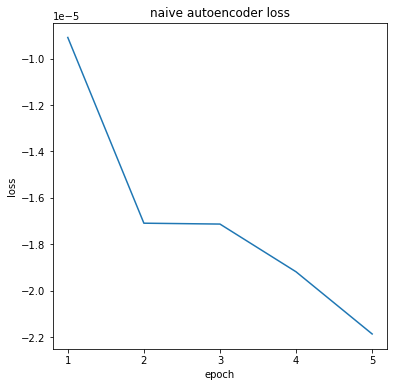

In [89]:
plt.figure(figsize=(6,6))
plt.title('naive autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

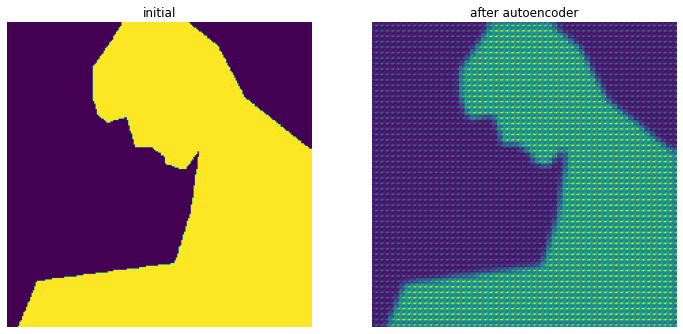

In [128]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
index = np.random.randint(len(val_loader.dataset))
img = val_loader.dataset[index]
plt.title('initial')
plt.axis('off')
plt.imshow(img.squeeze().numpy());

fig.add_subplot(1, 2, 2)
img = Variable(img).to(device)
img_encoded = naive_autoencoder(img.unsqueeze(0))
plt.title('after autoencoder')
plt.axis('off')
plt.imshow(img_encoded.cpu().detach().numpy().squeeze());

In [162]:
class Autoencoder(nn.Module):
  def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.encoder = nn.Sequential(
        nn.Conv2d(1, 128, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
      #  nn.BatchNorm2d(128),

        nn.Conv2d(128, 64, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
      #  nn.BatchNorm2d(64),

        nn.Conv2d(64, 16, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
      #  nn.BatchNorm2d(16),

        nn.Conv2d(16, 2, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
        )
        # decoder layers
        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(2, 16, 2, stride=2, padding=0),
        nn.ReLU(),
     #   nn.BatchNorm2d(16),

        nn.ConvTranspose2d(16, 32, 2, stride=2, padding=0),
        nn.ReLU(),
     #   nn.BatchNorm2d(32),

        nn.ConvTranspose2d(32, 64, 2, stride=2, padding=0),
        nn.ReLU(),
     #   nn.BatchNorm2d(64),

        nn.ConvTranspose2d(64, 1, 2, stride=2, padding=0),
        nn.Sigmoid()
        )

    
  def forward(self, x):
        # encode
        
        x = self.encoder(x)

        # decode
        x = self.decoder(x)
        return x

In [163]:
model = Autoencoder().to(device)
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 224, 224]           1,280
              ReLU-2        [-1, 128, 224, 224]               0
         MaxPool2d-3        [-1, 128, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          73,792
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 16, 56, 56]           9,232
              ReLU-8           [-1, 16, 56, 56]               0
         MaxPool2d-9           [-1, 16, 28, 28]               0
           Conv2d-10            [-1, 2, 28, 28]             290
             ReLU-11            [-1, 2, 28, 28]               0
        MaxPool2d-12            [-1, 2, 14, 14]               0
  ConvTranspose2d-13           [-1, 16, 28, 28]             144
             ReLU-14           [-1, 16,

In [165]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Autoencoder().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.MSELoss()
criterion = DiceLoss()
num_epochs = 10

In [166]:
conv_autoencoder, loss_history_ae = train_autoencoder(model, criterion, opt, val_loader, num_epochs, epoch_len=200)


  0%|          | 1/200 [00:00<00:26,  7.61it/s]

epoch [1/10], loss:0.0010



  0%|          | 1/200 [00:00<00:26,  7.39it/s]

epoch [2/10], loss:0.0000



  0%|          | 1/200 [00:00<00:26,  7.41it/s]

epoch [3/10], loss:0.0000



  0%|          | 1/200 [00:00<00:28,  6.97it/s]

epoch [4/10], loss:0.0000



  0%|          | 1/200 [00:00<00:28,  6.91it/s]

epoch [5/10], loss:0.0000



  0%|          | 1/200 [00:00<00:24,  7.96it/s]

epoch [6/10], loss:0.0000



  0%|          | 1/200 [00:00<00:25,  7.77it/s]

epoch [7/10], loss:0.0000



  0%|          | 1/200 [00:00<00:21,  9.19it/s]

epoch [8/10], loss:0.0000



  0%|          | 1/200 [00:00<00:23,  8.44it/s]

epoch [9/10], loss:0.0000



100%|██████████| 200/200 [00:24<00:00,  8.13it/s]


epoch [10/10], loss:0.0000



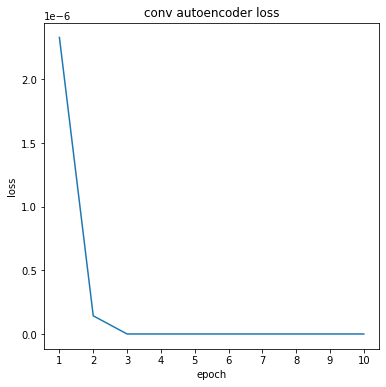

In [167]:
plt.figure(figsize=(6,6))
plt.title('conv autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

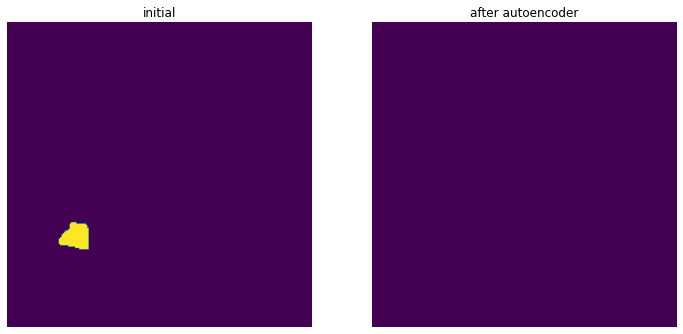

In [175]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
index = np.random.randint(len(val_loader.dataset))
img = val_loader.dataset[index]
plt.title('initial')
plt.axis('off')
plt.imshow(img.squeeze().numpy());

fig.add_subplot(1, 2, 2)
img = Variable(img).to(device)
img_encoded = conv_autoencoder(img.unsqueeze(0))
plt.title('after autoencoder')
plt.axis('off')
plt.imshow(img_encoded.cpu().detach().numpy().squeeze());

## Барахолка

In [ ]:
!git clone https://github.com/waleedka/coco
!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI

In [ ]:
from pycocotools.coco import COCO

annFile='annotations/instances_train2017.json'

coco=COCO(annFile)

In [ ]:
val_data = dset.CocoDetection(root = 'val2017',
                        annFile = 'annotations/instances_val2017.json',
                        transform=transform)

loading annotations into memory...
Done (t=0.72s)
creating index...
index created!


In [ ]:
target

[{'area': 16433.58065,
  'bbox': [120.07, 71.83, 134.49, 153.08],
  'category_id': 13,
  'id': 268988,
  'image_id': 724,
  'iscrowd': 0,
  'segmentation': [[122.51,
    174.51,
    120.07,
    110.94,
    159.68,
    71.83,
    220.33,
    81.13,
    253.1,
    128.57,
    254.56,
    186.77,
    220.33,
    224.91,
    165.55,
    224.91,
    123.98,
    178.45]]},
 {'area': 418.08004999999997,
  'bbox': [123.39, 279.44, 21.74, 30.17],
  'category_id': 8,
  'id': 1197746,
  'image_id': 724,
  'iscrowd': 0,
  'segmentation': [[124.76,
    280.61,
    128.09,
    286.88,
    142.98,
    289.04,
    145.13,
    299.42,
    142.59,
    304.12,
    141.8,
    309.61,
    134.95,
    309.61,
    132.21,
    305.1,
    130.44,
    307.26,
    126.53,
    305.69,
    123.78,
    305.69,
    123.39,
    279.44]]},
 {'area': 79.60360000000011,
  'bbox': [128.26, 267.21, 12.88, 8.15],
  'category_id': 3,
  'id': 1341991,
  'image_id': 724,
  'iscrowd': 0,
  'segmentation': [[130.39,
    267.21,

500


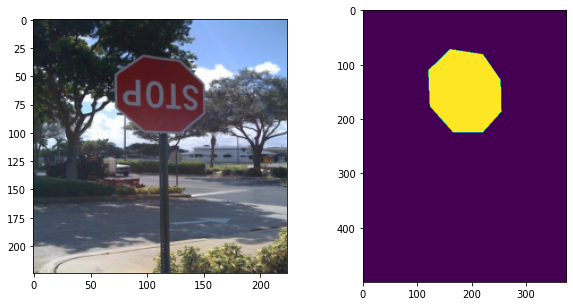

In [ ]:
img, target = val_data[3]

fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1,2,1)
plt.imshow(img.numpy().transpose((1, 2, 0)));

fig.add_subplot(1,2,2)
mask = val_data.coco.annToMask(target[0])
plt.imshow(mask);
print(len(mask))

In [ ]:
def load_data(batch_size=64):

  transform = transforms.Compose(
      [transforms.Resize([224,224]),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]
  )
  #transform = transforms.ToTensor()
  train_data = dset.CocoDetection(root = 'train2017',
                        annFile = 'annotations/instances_train2017.json',
                        transform=transform)

  print('Number of samples in train: ', len(train_data))

  val_data = dset.CocoDetection(root = 'val2017',
                        annFile = 'annotations/instances_val2017.json',
                        transform=transform)

  print('Number of samples in val: ', len(val_data))

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader

[]

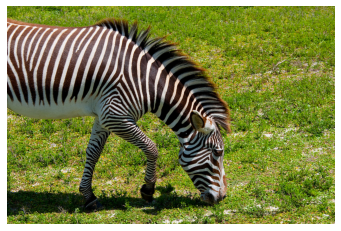

In [ ]:
plt.imshow(img.numpy().transpose((1, 2, 0)));
plt.axis('off')
catIds = [target[0]['category_id']]
annIds = train_data.coco.getAnnIds(imgIds=[target[0]['id']], catIds=catIds)
anns = train_data.coco.loadAnns(annIds)
train_data.coco.showAnns(anns)
annIds


In [ ]:
img, target = val_data[3]

In [ ]:
mask = val_data.coco.annToMask(target[0])


In [ ]:
t=transforms.ToPILImage()
mask_im = t(mask)
t = transforms.ToTensor()
t(mask_im).shape

torch.Size([1, 500, 375])

In [ ]:
type(mask_im)

PIL.Image.Image

In [ ]:
k = 3
x = torch.Tensor(np.ones((5, 3,16,16)))
x

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
        

In [ ]:
F.interpolate(x, (32, 32)).shape

torch.Size([5, 3, 32, 32])